In [1]:
import pandas as pd
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from os import environ

environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

from utils import hello_world
hello_world()

Hello World!


In [2]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

# TensorFlow Probability

### Probabilistic Programming in TensorFlow!

In [3]:
!pip install --upgrade tensorflow-probability

Requirement already up-to-date: tensorflow-probability in /home/capcolabs/Stevens/Machine-Learning-Algorithms/venv/lib/python3.7/site-packages (0.8.0)
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

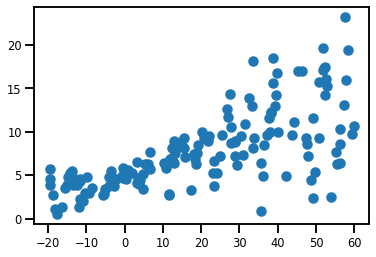

In [5]:
plt.scatter(x,y)

In [6]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [8]:
# Build model.

def build_model_00():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(1),
      tfp.layers.DistributionLambda(
          lambda t: tfd.Normal(loc=t, scale=1)),
    ])
    return model

model = build_model_00()

# Do inference.
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01), 
    loss=negloglik)
model.fit(
    x, y, 
    epochs=1000, verbose=False
)
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.13940002
5.1319637


In [9]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## No Uncertainty

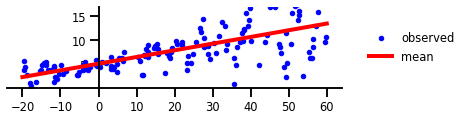

In [10]:
#@title Figure 1: No uncertainty.
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='mean', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig1.png', bbox_inches='tight', dpi=300)

## Aleatoric Uncertainty

- https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty

>Aleatoric uncertainty is also known as statistical uncertainty, and is representative of unknowns that differ each time we run the same experiment. For example, a single arrow shot with a mechanical bow that exactly duplicates each launch (the same acceleration, altitude, direction and final velocity) will not all impact the same point on the target due to random and complicated vibrations of the arrow shaft, the knowledge of which cannot be determined sufficiently to eliminate the resulting scatter of impact points. The argument here is obviously in the definition of "cannot". Just because we cannot measure sufficiently with our currently available measurement devices does not preclude necessarily the existence of such information, which would move this uncertainty into the below category. Aleatoric is derived from the Latin alea or dice, referring to a game of chance.

In [11]:
# Build model.

def build_model_01():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(1 + 1),
      tfp.layers.DistributionLambda(
          lambda t: tfd.Normal(
              loc=t[..., :1],
              scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
    ])
    return model

model = build_model_01()

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[0.12220287 0.91734254]
[5.1916466 2.3943453]


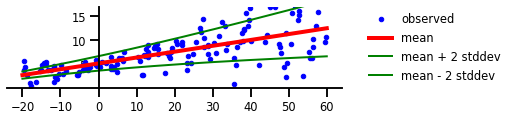

In [12]:
#@title Figure 2: Aleatoric Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

## Epistemic Uncertainty

- https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty

>Epistemic uncertainty is also known as systematic uncertainty, and is due to things one could in principle know but doesn't in practice. This may be because a measurement is not accurate, because the model neglects certain effects, or because particular data has been deliberately hidden. An example of a source of this uncertainty would be the drag in an experiment designed to measure the acceleration of gravity near the earth's surface. The commonly used gravitational acceleration of 9.8 m/s^2 ignores the effects of air resistance, but the air resistance for the object could be measured and incorporated into the experiment to reduce the resulting uncertainty in the calculation of the gravitational acceleration.

In [14]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [15]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [16]:
# Build model.

def build_model_02():
    model = tf.keras.Sequential([
      tfp.layers.DenseVariational(
          1, 
          posterior_mean_field, 
          prior_trainable, 
          kl_weight=1/x.shape[0]),
      tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
    ])
    return model

model = build_model_02()

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.13171068  5.1223454  -3.962767   -2.315134  ]
[0.14849219 5.124105  ]


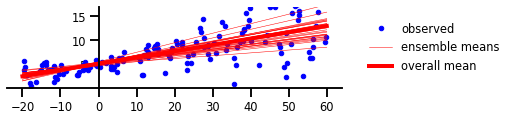

In [17]:
#@title Figure 3: Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig3.png', bbox_inches='tight', dpi=300)

## Aleatoric & Epistemic Uncertainty

In [18]:
# Build model.

def build_model_03():
    model = tf.keras.Sequential([
      tfp.layers.DenseVariational(
          1 + 1, 
          posterior_mean_field, 
          prior_trainable, 
          kl_weight=1/x.shape[0]
      ),
      tfp.layers.DistributionLambda(
          lambda t: tfd.Normal(loc=t[..., :1],
                               scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
    ])
    return model

model = build_model_03()

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.1417829   2.2783957   5.168747    3.2429857  -3.2439198  -0.63499516
 -1.9244666   0.01892801]
[0.14797452 2.2272666  5.1482573  3.1907184 ]


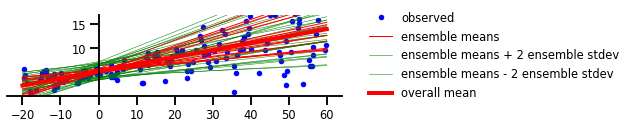

In [19]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)

## Functional Uncertainty

In [20]:
#@title Custom PSD Kernel
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')
    
    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

In [21]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

# Build model.
num_inducing_points = 40
def build_model_04():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[1]),
        tf.keras.layers.Dense(
            1, 
            kernel_initializer='ones', 
            use_bias=False),
        tfp.layers.VariationalGaussianProcess(
            num_inducing_points=num_inducing_points,
            kernel_provider=RBFKernelFn(),
            event_shape=[1],
            inducing_index_points_initializer=tf.constant_initializer(
                np.linspace(*x_range, num=num_inducing_points,
                            dtype=x.dtype)[..., np.newaxis]),
            unconstrained_observation_noise_variance_initializer=(
                tf.constant_initializer(np.array(0.54).astype(x.dtype))),
        ),
    ])
    return model

model = build_model_04()

# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01), 
    loss=loss
)
model.fit(
    x, y, 
    batch_size=batch_size, 
    epochs=1000, 
    verbose=False
)

# Profit.
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

Instructions for updating:
Please use `layer.add_weight` method instead.


/home/capcolabs/Stevens/Machine-Learning-Algorithms/venv/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: tfp.positive_semidefinite_kernels module has been moved to tfp.math.psd_kernels. This alias will be deleted on 2019-12-01



If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



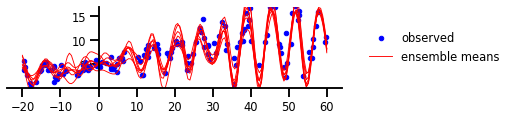

In [22]:
#@title Figure 5: Functional Uncertainty

y, x, _ = load_dataset()

plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

num_samples = 7
for i in range(num_samples):
  sample_ = yhat.sample().numpy()
  plt.plot(x_tst,
           sample_[..., 0].T,
           'r',
           linewidth=0.9,
           label='ensemble means' if i == 0 else None);

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

plt.savefig(
    '/tmp/fig5.png', 
    bbox_inches='tight', 
    dpi=300
)